In [2]:
import numpy as np
import pandas as pd
from scipy.special import logit, expit
from scipy.stats import bernoulli
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az
from modeltools import plot_prior_postrr, create_summary_stat, mcmc_diagnostics 
from downcast import downcast_df

In [3]:
raw_data = pd.read_csv("data/unit_level_ratings.csv",index_col = 0)
raw_data = raw_data.sort_values(by=["corpus", "model", "topic"])

In [4]:
# Creating identifier for each corpus, model, and topic
# Identifier is unique for topic 
corpus_ids = (raw_data.groupby(["corpus"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
corpus_ids["corpus_id"] = corpus_ids.index

model_ids = (raw_data.groupby(["model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
model_ids["model_id"] = model_ids.index

cordel_ids = (raw_data.groupby(["corpus", "model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
cordel_ids["cordel_id"] = cordel_ids.index 

topic_ids = (raw_data.groupby(["corpus", "model", "topic"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
topic_ids["topic_id"] = topic_ids.index 

rater_ids = (raw_data.groupby(["corpus", "rater"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
rater_ids["rater_id"] = rater_ids.index 


d1 = pd.merge(raw_data, corpus_ids, on=["corpus"], how="left")
d2 = pd.merge(d1, model_ids, on=["model"], how="left")
d3 = pd.merge(d2, cordel_ids, on=["corpus","model"], how="left")
d4 = pd.merge(d3, rater_ids, on=["corpus", "rater"], how="left")
data = pd.merge(d4, topic_ids, on=["corpus", "model", "topic"], how="left")
data = data[["corpus_id", "model_id", "cordel_id", "topic_id", "rater_id", "intrusion", "confidence"]]
data, na_s = downcast_df(data)

In [5]:
# Setting up numpy arrays for pymc
corpus_array = np.array(data["corpus_id"])
n_corpora = data["corpus_id"].nunique()

model_array = np.array(data["model_id"])
n_models = data["model_id"].nunique()

cordel_array = np.array(data["cordel_id"])
n_cordels = data["cordel_id"].nunique()

topic_array = np.array(data["topic_id"])
n_topics = data["topic_id"].nunique()

rater_array = np.array(data["rater_id"])
n_raters = data["rater_id"].nunique()

score_array = np.array(data["intrusion"])

In [28]:
# Model and MCMC specifications

n_cores = 4
emprical_mean = logit(0.75)
r_lambda = 2
t_lambda = 1
t_sigma = 0.3
cm_lambda = 2
cm_sigma = 0.3
mu_sigma = 1

## Model

In [29]:
# Collection of model, trace, prior & posterior simulations
# {"model": pm.Model, 
#  "trace": az.InferenceData, 
#  "prior_sim": az.InferenceData, 
#  "postrr_sim": az.InferenceData}

glm_rater_topic_cordel = {"model":pm.Model()}

In [30]:
# Rater, Topic and cordel model

glm_rater_topic_cordel["model"] = pm.Model()
with glm_rater_topic_cordel["model"]:
    # Hyperparameter priors
# Changing the scale of zc and zr has no effect on the model as sigma_c and sigma_a are also free params 
    sigma_c = pm.Exponential("sigma_c", lam=cm_lambda)
    zc = pm.Normal("zc",mu=emprical_mean, sigma=cm_sigma, shape=n_cordels)
    sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
    zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda, shape=n_cordels)
    za = pm.Normal("za",mu=0, sigma=t_sigma, shape=n_topics) 
    
    p = pm.math.invlogit(
        za[topic_array]*sigma_a[cordel_array]+
        zc[cordel_array]*sigma_c+
        zr[rater_array]*sigma_r)
    s = pm.Bernoulli("s", p=p, observed=score_array)

    glm_rater_topic_cordel["trace"]=pm.sample(cores=n_cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_c, zc, sigma_r, zr, sigma_a, za]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 188 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


## Diagnostics

In [31]:
glm = glm_rater_topic_cordel
glm

{'model': sigma_c ~ Exp(f())
      zc ~ N(1.1, 0.3)
 sigma_r ~ Exp(f())
      zr ~ N(0, 1)
 sigma_a ~ Exp(f())
      za ~ N(0, 0.3)
       s ~ Bern(f(sigma_r, zr, sigma_c, zc, sigma_a, za)),
 'trace': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data}

========================== trace diagnostics ==========================
Divergent transitions
0    0
1    0
2    1
3    0
dtype: int64


Variable with highest rhat
['sigma_a', 4, 1.0126]


Variable with lowest effective sample size
['sigma_a', 1, 528.5273]


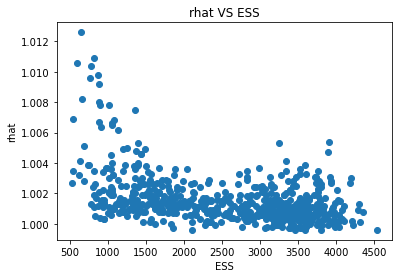

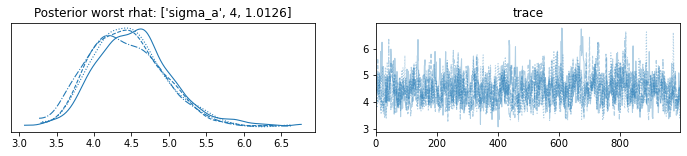

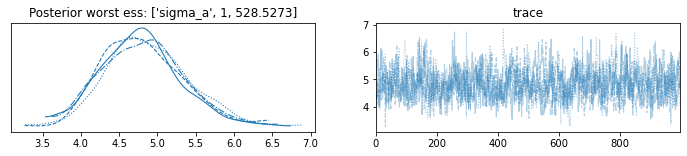

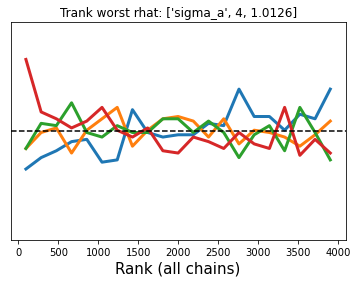

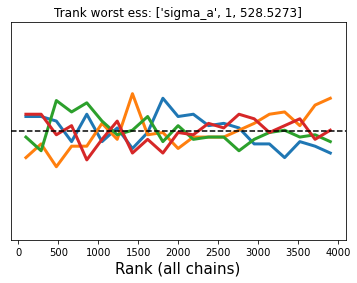

In [32]:
summary_stat = create_summary_stat(glm["trace"])
mcmc_diagnostics(glm["trace"], summary_stat)

In [27]:
summary_stat_4 = summary_stat

In [33]:
summary_stat[(summary_stat["param"]!="za") & (summary_stat["param"]!="zr")]

,param,param_num,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,zc,0,1.3196,0.1897,0.9645,1.6731,0.0067,0.0048,798.3928,1302.6424,1.0024
1,zc,1,0.8764,0.1881,0.5319,1.2245,0.0080,0.0057,543.9640,880.9787,1.0035
2,zc,2,1.1632,0.1971,0.7927,1.5380,0.0076,0.0054,679.2894,928.6788,1.0051
3,zc,3,1.2699,0.1833,0.9383,1.6184,0.0058,0.0041,973.9615,1361.0172,1.0037
4,zc,4,1.0616,0.1875,0.7200,1.4161,0.0081,0.0057,534.6846,1121.8680,1.0069
5,zc,5,1.1455,0.1823,0.8229,1.5041,0.0067,0.0047,738.9052,1234.2676,1.0039
627,sigma_c,NaN,1.1120,0.1437,0.8629,1.4015,0.0056,0.0041,682.2518,738.3360,1.0028
628,sigma_r,NaN,0.5058,0.0357,0.4411,0.5724,0.0011,0.0008,1170.7212,1582.9704,1.0025
629,sigma_a,0,4.1213,0.4947,3.2520,5.0464,0.0192,0.0136,655.3965,1410.5118,1.0082
630,sigma_a,1,4.8211,0.5308,3.8841,5.8516,0.0229,0.0162,528.5273,1166.4877,1.0027


In [40]:
summary_stat_4[(summary_stat["param"]!="za") & (summary_stat["param"]!="zr")]

,param,param_num,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,zc,0,1.3912,0.2331,0.9645,1.8328,0.0058,0.0041,1590.6813,2124.9252,1.0017
1,zc,1,0.8848,0.2139,0.4892,1.2716,0.0060,0.0043,1251.7573,1830.0224,1.0009
2,zc,2,1.2268,0.2324,0.7875,1.6394,0.0059,0.0042,1513.0589,1971.3450,1.0012
3,zc,3,1.3457,0.2217,0.9201,1.7544,0.0052,0.0037,1750.5714,2034.4322,1.0007
4,zc,4,1.1064,0.2145,0.7174,1.5273,0.0057,0.0040,1407.3029,2112.7616,1.0057
5,zc,5,1.1991,0.2141,0.8072,1.6125,0.0051,0.0036,1744.5380,1960.8866,1.0032
627,sigma_c,NaN,1.0632,0.1543,0.8011,1.3563,0.0036,0.0026,1932.5238,1873.1364,1.0032
628,sigma_r,NaN,0.5086,0.0350,0.4446,0.5770,0.0008,0.0005,2138.4796,3092.6401,1.0003
629,sigma_a,0,3.1820,0.3924,2.4957,3.9358,0.0109,0.0077,1299.7544,2143.3284,1.0028
630,sigma_a,1,3.6361,0.4072,2.9146,4.4334,0.0112,0.0079,1327.1130,2403.6410,1.0009


In [43]:
1.139367*1.1120

1.266976104

In [42]:
 1.192333*1.0632

1.2676884456

In [44]:
summary_stat[summary_stat["param"]=="zc"]["mean"]*1.1120

0    1.467395
1    0.974557
2    1.293478
3    1.412129
4    1.180499
5    1.273796
Name: mean, dtype: float64

In [46]:
summary_stat_4[summary_stat["param"]=="zc"]["mean"]*1.0632

0    1.479124
1    0.940719
2    1.304334
3    1.430748
4    1.176324
5    1.274883
Name: mean, dtype: float64

In [35]:
summary_stat_4[(summary_stat["param"]!="za") & (summary_stat["param"]!="zr")]

,param,param_num,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,zc,0,1.3912,0.2331,0.9645,1.8328,0.0058,0.0041,1590.6813,2124.9252,1.0017
1,zc,1,0.8848,0.2139,0.4892,1.2716,0.0060,0.0043,1251.7573,1830.0224,1.0009
2,zc,2,1.2268,0.2324,0.7875,1.6394,0.0059,0.0042,1513.0589,1971.3450,1.0012
3,zc,3,1.3457,0.2217,0.9201,1.7544,0.0052,0.0037,1750.5714,2034.4322,1.0007
4,zc,4,1.1064,0.2145,0.7174,1.5273,0.0057,0.0040,1407.3029,2112.7616,1.0057
5,zc,5,1.1991,0.2141,0.8072,1.6125,0.0051,0.0036,1744.5380,1960.8866,1.0032
627,sigma_c,NaN,1.0632,0.1543,0.8011,1.3563,0.0036,0.0026,1932.5238,1873.1364,1.0032
628,sigma_r,NaN,0.5086,0.0350,0.4446,0.5770,0.0008,0.0005,2138.4796,3092.6401,1.0003
629,sigma_a,0,3.1820,0.3924,2.4957,3.9358,0.0109,0.0077,1299.7544,2143.3284,1.0028
630,sigma_a,1,3.6361,0.4072,2.9146,4.4334,0.0112,0.0079,1327.1130,2403.6410,1.0009


In [49]:
# Checking average value topic parameter value for each cordel
summary_stat["cordel"]=summary_stat["param_num"].astype(np.float32)//50
summary_stat[summary_stat["param"]=="za"].groupby("cordel").agg({"mean":"mean"})

,mean
cordel,
0.0,0.021216
1.0,-0.014054
2.0,0.011752
3.0,0.014460
4.0,0.002372
5.0,0.008118


In [13]:
def plot_prior_postrr(prior_pred, postrr_pred, data, target="s"):
    # Prior
    # Plotting distribution of scores simulated from prior
    prior_samples = prior_pred.prior_predictive.sel(chain=0)
    postrr_samples = postrr_pred.posterior_predictive.sel(chain=0)

    # Manipulating samples to plot
    df_prior, na_s = downcast_df(prior_samples[target].to_dataframe().reset_index())
    df_postrr, na_s = downcast_df(postrr_samples[target].to_dataframe().reset_index())

    # Joining rater/topic/model/corpus information
    data1 = data.copy()
    data1[f"{target}_dim_0"] = data1.index
    df_prior1 = pd.merge(df_prior, data1, on=target+"_dim_0", how="left")
    df_postrr1 = pd.merge(df_postrr, data1, on=target+"_dim_0", how="left")

    # Aggregating "1s" and counts by topic
    prior_agg = df_prior1.groupby(["draw", "topic_id"]).agg({target:["sum", "count"]}).reset_index()
    postrr_agg = df_postrr1.groupby(["draw", "topic_id"]).agg({target:["sum", "count"]}).reset_index()
    obs_agg = df_prior1[df_prior1["chain"]==0].groupby(["draw", "topic_id"]).agg({"intrusion":["sum", "count"]}).reset_index()

    # Calculating topic probabilities from sums and counts
    prior_topic_prob = prior_agg[("s","sum")]/prior_agg[("s","count")]
    postrr_topic_prob = postrr_agg[("s","sum")]/postrr_agg[("s","count")]
    obs_topic_prob = obs_agg[("intrusion","sum")]/obs_agg[("intrusion","count")]

    # Setting up plot
    plot, ax = plt.subplots(1, 1,figsize=(10,6))
    ax = az.plot_kde(np.array(prior_topic_prob), bw=0.05)
    ax.get_lines()[0].set_color("orange")
    ax.get_lines()[0].set_linestyle("--")
    ax = az.plot_kde(np.array(postrr_topic_prob), bw=0.05)
    ax.get_lines()[1].set_color("green")
    ax.get_lines()[1].set_linestyle("--")
    ax = az.plot_kde(np.array(obs_topic_prob), bw=0.05)
    ax.set_title("Prior dist: number of 1's per topic")
    ax.set_ylabel("Density")
    ax.set_xlabel("p")
    ax.legend(ax.get_lines(), ["Prior", "Posterior", "Observed"])

    plt.plot()


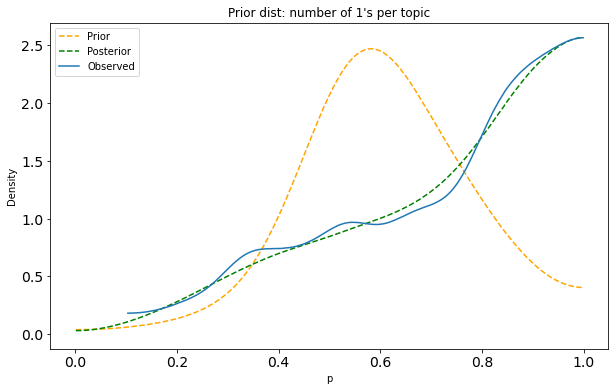

In [14]:
with glm["model"]:
    glm["prior_sim"]=pm.sample_prior_predictive(1_000)
    glm["postrr_sim"]=pm.sample_posterior_predictive(glm["trace"])
plot_prior_postrr(glm["prior_sim"], glm["postrr_sim"], data)

/tmp/ipykernel_7145/213989127.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left.loc[:,"param_num"]=left["param_num"].astype(int)


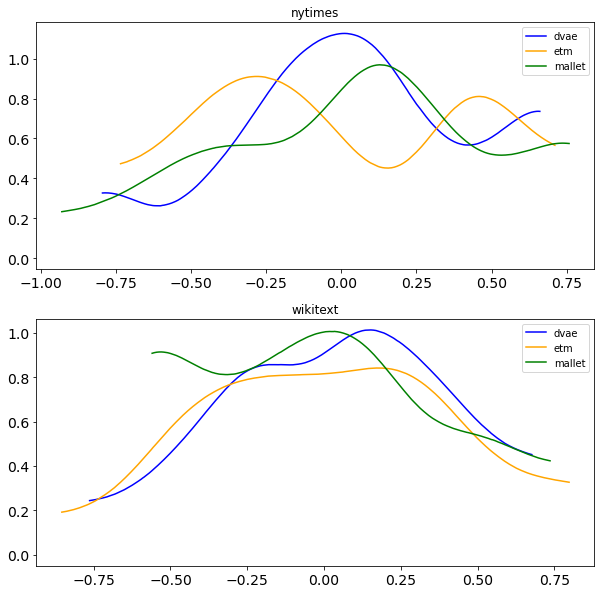

In [16]:
# Plot distribution of topic location params
left = summary_stat[summary_stat["param"]=="za"]
left.loc[:,"param_num"]=left["param_num"].astype(int)
test = pd.merge(left, topic_ids, left_on="param_num", right_on="topic_id", how="left")

corpora = {"nytimes":"-", "wikitext":"-"}
models = {"dvae":"blue", "etm":"orange", "mallet":"green"}

fig, axs = plt.subplots(2, 1, figsize=(10,10))

for i, corpus in enumerate(corpora):
    for model in models:
        az.plot_kde(np.array(test[(test["corpus"]==corpus) & (test["model"]==model)]["mean"]), ax=axs[i])
        axs[i].get_lines()[-1].set_linestyle(corpora[corpus])
        axs[i].get_lines()[-1].set_color(models[model])
    axs[i].set_title(corpus)
    axs[i].legend(axs[i].get_lines(), models.keys())